In [471]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [472]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

<h5>Data Preprocessing<h5>

In [473]:
#downloading mnist data and storing it in tghe path varriable

#Can check the path with path.ls()

path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [474]:
#Seperating path of three and seven

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

threes_valid = (path/'valid'/'3').ls().sorted()
sevens_valid = (path/'valid'/'7').ls().sorted()

In [475]:
# for testing showing a image data of three

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [476]:
# Converting a image to tensor and putting the tensor in a dataframe
# we get dataframe from pandas

im3_t = tensor(im3)
df = pd.DataFrame(im3_t)

#use the code below the show the tensor data
#df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [477]:
# Converting all the images to tensor by looping through the path

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]


seven_tensors_valid = [tensor(Image.open(o)) for o in sevens_valid]
three_tensors_valid = [tensor(Image.open(o)) for o in threes_valid]

len(three_tensors),len(seven_tensors),len(three_tensors_valid),len(seven_tensors_valid)

(6131, 6265, 1010, 1028)

In [478]:
# stacking all the tensors and making it 3 dimensional matrix

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

stacked_sevens_valid = torch.stack(seven_tensors_valid).float()/255
stacked_threes_valid = torch.stack(three_tensors_valid).float()/255

stacked_threes.shape

torch.Size([6131, 28, 28])

In [479]:
#making all the matrix a vector 
#for every individual pixel we getting data for the all image 
#pytorch is concatanating the values

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [480]:
#Y is using for labeling
#it will label the threes in 1 and sevens in 0


train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [481]:
#dataset is using for tupple
#for the first image we are getting 784 pixel for x and 1 label for y

dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y.shape

(torch.Size([784]), torch.Size([1]))

In [482]:
#repeating the process for validation set


valid_x = torch.cat([stacked_threes_valid, stacked_sevens_valid]).view(-1, 28*28)
valid_y = tensor([1]*len(threes_valid) + [0]*len(sevens_valid)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

<h5>Initialize the parameters<h5>

In [483]:
#initialising parameters function with requires_grad
#requires_grad_ is for gradient descent

def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

#initialising weights for every pixel

weights = init_params((28*28,1))
weights.shape

torch.Size([784, 1])

In [484]:
#initialising a random bias

bias = init_params(1)
bias

tensor([0.7589], requires_grad=True)

<h6>loss function<h6>

In [485]:
#calculate a prediction for one image
#(X*W)+b

(train_x[0]*weights.T).sum() + bias
#train_x[0].shape

tensor([2.4918], grad_fn=<AddBackward0>)

In [486]:
#function for calculating for all the images
# @ represents matrix multiplication

def linear1(xb): return xb@weights + bias

#passing train X 
preds = linear1(train_x)
preds

tensor([[ 2.4918],
        [ 6.1606],
        [ 7.7278],
        ...,
        [19.7293],
        [19.3894],
        [10.2566]], grad_fn=<AddBackward0>)

In [487]:
# checking accuracy

corrects = (preds>0.5).float() == train_y
corrects.float()


tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [488]:
#accuracy percenatge

corrects.float().mean()

tensor(0.4255)

In [489]:
with torch.no_grad():
         weights[0] *= 1.0001

In [490]:
preds = linear1(train_x)
((preds>0.5).float() == train_y).float().mean().item()

0.4255405068397522

<h6>Better loss function with Sigmoid<h6>

In [491]:
#defining sigmoid function which give value 1>x>0
# sigmoid(x) = 1/1+e^(-x)

def sigmoid(x): return 1/(1+torch.exp(-x))

In [492]:
#defining new loss function with sigmoid
# torch where is like a if else statement
#if taget is 1 do 1-predictions, if not return prediction

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [493]:
#dataloader is used for minibatches
# we are providing our previous dataset to dataloader with a minibatch of 256

dl = DataLoader(dset, batch_size=256)

#first(dl) is used for showing first batch of data
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [494]:
#repeating for the validation set

valid_dl = DataLoader(valid_dset, batch_size=256)

<h5>Calculate the gradient. training model, validation mode<h5>

In [495]:
#defining the calculation of gradient descent

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [496]:
#inititaing zero for epochs as _ will change in instance for all weights and biases

#weights.grad.zero_()
#bias.grad.zero_();

In [497]:
#loading batches from the dataloader
#calculating gradient
#updating data of parameters
#making parameters 0 again
#parameter data and parameter grad are two different things

def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()
            
#inititaing zero for epochs as _ will change in instance for all weights and biases
#weights.grad.zero_()
#bias.grad.zero_();

In [498]:
#defining function for checking accuracy of batche

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [499]:
# getting every batch accuracy by looping throught validation dataloader
#stacking the accuracies and calcualting mean by rounding 4 decimal

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

<h5>Train the model and validating<h5>

In [500]:
# iterating 20 times with a learning rate of lr


lr = 1
params = weights, bias
for i in range(100):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.4897 0.4922 0.4927 0.4927 0.4937 0.4937 0.4985 0.5731 0.6943 0.8525 0.9126 0.9385 0.9477 0.9555 0.9609 0.9629 0.9653 0.9658 0.9682 0.9707 0.9712 0.9712 0.9712 0.9721 0.9721 0.9731 0.9741 0.9746 0.9741 0.9746 0.9746 0.9741 0.9746 0.9741 0.9746 0.9746 0.9751 0.9751 0.9751 0.9751 0.9751 0.9751 0.9756 0.9756 0.977 0.9765 0.9765 0.977 0.977 0.977 0.9775 0.978 0.978 0.978 0.9785 0.9785 0.978 0.978 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9785 0.9795 0.9795 0.9795 0.98 0.98 0.98 0.98 0.9804 0.9804 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9809 0.9814 0.9814 0.9814 0.9814 0.9814 0.9814 

<h3> MNIST Optimised Version <h3>

In [501]:
#refractoring parameters initialising and linear1 function
linear_model = nn.Linear(28*28,1)

w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [502]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [503]:
learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.635989,0.503261,0.495584,00:00
1,0.456262,0.224228,0.799804,00:00
2,0.169806,0.168758,0.849362,00:00
3,0.075784,0.102729,0.914622,00:00
4,0.041110,0.075918,0.932777,00:00
5,0.027517,0.061177,0.947988,00:00
6,0.021888,0.051928,0.957802,00:00
7,0.019353,0.045760,0.962218,00:00
8,0.018045,0.041426,0.965653,00:00
9,0.017247,0.038231,0.968597,00:00


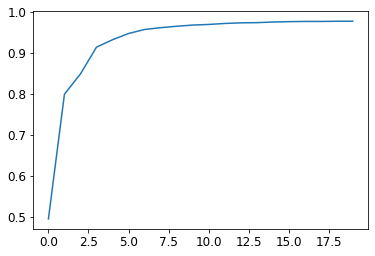

In [504]:
plt.plot(L(learn.recorder.values).itemgot(2));

<h5>Simple neural net <h5>

In [505]:
#ReLU is used for changing neg numbers to 0

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [506]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [507]:

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.289872,0.413856,0.505397,00:00
1,0.138481,0.218120,0.816977,00:00
2,0.077903,0.111061,0.918057,00:00
3,0.051943,0.075491,0.942591,00:00
4,0.039760,0.059015,0.959274,00:00
5,0.033457,0.049777,0.963690,00:00
6,0.029791,0.043975,0.967125,00:00
7,0.027387,0.040014,0.967615,00:00
8,0.025642,0.037130,0.970559,00:00
9,0.024285,0.034923,0.972031,00:00


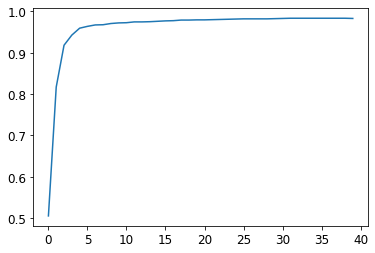

In [508]:
plt.plot(L(learn.recorder.values).itemgot(2));

<h5>18 layer neural net <h5>

In [509]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(20, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.049823,0.012766,0.996565,00:05
1,0.052833,0.030058,0.990677,00:05
2,0.283216,0.369350,0.969578,00:05
3,0.131393,0.022811,0.994112,00:05
4,0.260839,0.061273,0.997056,00:05
5,0.456175,0.163104,0.996075,00:05
6,0.479453,1.717188,0.966634,00:05
7,0.134605,0.683783,0.976938,00:05
8,0.296857,0.456689,0.989205,00:05
9,0.321756,0.119356,0.997056,00:05
